In [ ]:
# prompt: install tensor flow 2.8.0, keras=2.8.0,tensorflow-addons=0.17.0 #(0.20.0)

!pip install tensorflow==2.8.0 keras==2.8.0 tensorflow-addons==0.17.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 35.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72
patch_size = 6
projection_dim = 64
num_heads = 4
transformer_units =[
    projection_dim * 2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental
        .preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        )
    ]
)
data_augmentation.layers[0].adapt(x_train)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
      batch_size = tf.shape(images)[0]
      patches = tf.image.extract_patches(
          images=images,
          sizes=[1, self.patch_size, self.patch_size, 1],
          strides=[1, self.patch_size, self.patch_size, 1],
          rates=[1, 1, 1, 1],
          padding="VALID",
      )
      patch_dims = patches.shape[-1]
      patches = tf.reshape(patches, [batch_size, -1, patch_dims])
      return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


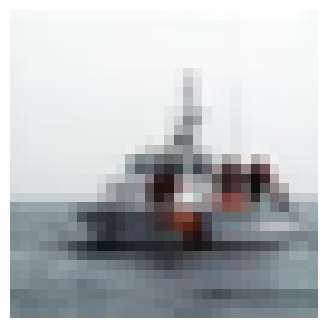

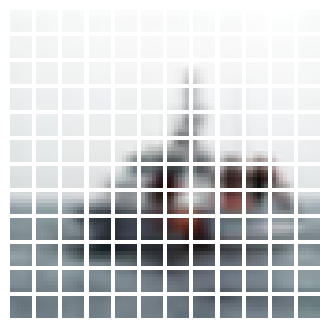

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
from re import A
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes)(features)

    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )
  model.compile(
      optimizer=optimizer,
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
          keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
          keras.metrics
          .SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
      ],
  )
  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )

  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[checkpoint_callback],
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

  return history

In [ ]:
# Calculate num_patches based on image_size and patch_size
num_patches = (image_size // patch_size) ** 2

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    # num_patches is now defined and can be passed to PatchEncoder
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes)(features)

    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/40
176/176 [==============================] - 3391s 19s/step - loss: 2.0346 - accuracy: 0.3144 - top-5-accuracy: 0.8098 - val_loss: 1.5274 - val_accuracy: 0.4532 - val_top-5-accuracy: 0.9118
Epoch 2/40
 11/176 [>.............................] - ETA: 48:53 - loss: 1.6519 - accuracy: 0.4045 - top-5-accuracy: 0.8739